In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

# TensorFlow и tf.keras
import tensorflow as tf
import torch
from tensorflow import keras
#import keras
# Вспомогательные библиотеки
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import cv2

from keras.models import Model
from keras.layers import Input, Dense, Concatenate, Flatten, BatchNormalization
from keras.layers import Dense, GlobalAveragePooling2D, Dropout, UpSampling2D, Conv2D, MaxPooling2D, Activation

print(tf.__version__)

1.15.0


Using TensorFlow backend.


In [2]:
!unzip train_slant.zip #images

Archive:  train_slant.zip
  inflating: train_slant/1.jpg       
  inflating: train_slant/10.jpg      
  inflating: train_slant/100.jpg     
  inflating: train_slant/1000.jpg    
  inflating: train_slant/101.jpg     
  inflating: train_slant/102.jpg     
  inflating: train_slant/103.jpg     
  inflating: train_slant/104.jpg     
  inflating: train_slant/105.jpg     
  inflating: train_slant/106.jpg     
  inflating: train_slant/107.jpg     
  inflating: train_slant/108.jpg     
  inflating: train_slant/109.jpg     
  inflating: train_slant/11.jpg      
  inflating: train_slant/110.jpg     
  inflating: train_slant/111.jpg     
  inflating: train_slant/112.jpg     
  inflating: train_slant/113.jpg     
  inflating: train_slant/114.jpg     
  inflating: train_slant/115.jpg     
  inflating: train_slant/116.jpg     
  inflating: train_slant/117.jpg     
  inflating: train_slant/118.jpg     
  inflating: train_slant/119.jpg     
  inflating: train_slant/12.jpg      
  inflating: train_slant

In [0]:
train = pd.read_csv('train_slant.csv')

In [4]:
train.head()

,img,slant
0,1.jpg,0
1,2.jpg,2
2,3.jpg,2
3,4.jpg,2
4,5.jpg,2


In [5]:
train.shape

(1000, 2)

In [6]:
train[train.slant == 0].shape, train[train.slant == 1].shape, train[train.slant == 2].shape #кол-во классов

((303, 2), (393, 2), (304, 2))

In [7]:
!unzip test_slant.zip #images

Archive:  test_slant.zip
  inflating: test_slant/100.jpg      
  inflating: test_slant/101.jpg      
  inflating: test_slant/102.jpg      
  inflating: test_slant/103.jpg      
  inflating: test_slant/104.jpg      
  inflating: test_slant/105.jpg      
  inflating: test_slant/107.jpg      
  inflating: test_slant/108.jpg      
  inflating: test_slant/109.jpg      
  inflating: test_slant/118.jpg      
  inflating: test_slant/119.jpg      
  inflating: test_slant/120.jpg      
  inflating: test_slant/121.jpg      
  inflating: test_slant/124.jpg      
  inflating: test_slant/125.jpg      
  inflating: test_slant/126.jpg      
  inflating: test_slant/127.jpg      
  inflating: test_slant/129.jpg      
  inflating: test_slant/131.jpg      
  inflating: test_slant/132.jpg      
  inflating: test_slant/133.jpg      
  inflating: test_slant/134.jpg      
  inflating: test_slant/135.jpg      
  inflating: test_slant/136.jpg      
  inflating: test_slant/137.jpg      
  inflating: test_slant/1

In [0]:
test = pd.read_csv('test_slant.csv')

In [9]:
test.head()

,img,slant
0,100.jpg,1
1,101.jpg,1
2,102.jpg,1
3,103.jpg,2
4,104.jpg,1


In [10]:
test.shape

(182, 2)

In [11]:
test[test.slant == 0].shape, test[test.slant == 1].shape, test[test.slant == 2].shape #кол-во классов

((53, 2), (73, 2), (56, 2))

In [0]:
hei = 128
wei = 64

**Добавление данных в x_test, y_test**

In [13]:
x_test = []
y_test = []

for i in range (test.shape[0]):
    x,y = test.values[i]
    x = cv2.imread('test_slant/{}'.format(x))
    #x = strong_aug(p=0.2)
    x = cv2.resize(x, (hei, wei))
    x_test += [x]
    y_test += [y]
    
x_test = np.array(x_test) / 255.
y_test = np.array(y_test)

x_test.shape

(182, 64, 128, 3)

**Генератор батчей для train**

In [0]:
#Объявим генератор
def keras_generator(gen_df, batch_size):#генератор картинок в батч (создание батча)
    while True:
        x_train = []
        y_train = []
        

        for i in range (batch_size):

            x,y = train.sample(1).values[0]
            x = cv2.imread('train_slant/{}'.format(x))
            #x = strong_aug(p=0.2)
            x = cv2.resize(x, (hei, wei))
            x_train += [x]
            y_train += [y]

        #y_train = keras.utils.to_categorical(y_train,10)
        x_train = np.array(x_train) / 255.
        y_train = np.array(y_train)

        yield x_train, y_train

**Архитектура сети**

In [0]:
inp = Input(shape=(wei, hei, 3))

conv_1_1 = Conv2D(32, (3, 3), padding='same')(inp)
conv_1_1 = Activation('relu')(conv_1_1)

conv_1_2 = Conv2D(32, (3, 3), padding='same')(conv_1_1)
conv_1_2 = Activation('relu')(conv_1_2)

pool_1 = MaxPooling2D(2)(conv_1_2)
pool_1 = Dropout(0.2)(pool_1)
pool_1 = BatchNormalization()(pool_1)

conv_2_1 = Conv2D(64, (3, 3), padding='same')(pool_1)
conv_2_1 = Activation('relu')(conv_2_1)

conv_2_2 = Conv2D(64, (3, 3), padding='same')(conv_2_1)
conv_2_2 = Activation('relu')(conv_2_2)

pool_2 = MaxPooling2D(2)(conv_2_2)
pool_2 = Dropout(0.2)(pool_2)
pool_2 = BatchNormalization()(pool_2)


conv_3_1 = Conv2D(128, (3, 3), padding='same')(pool_2)
conv_3_1 = Activation('relu')(conv_3_1)

conv_3_2 = Conv2D(128, (3, 3), padding='same')(conv_3_1)
conv_3_2 = Activation('relu')(conv_3_2) #conv_3_2.shape = (64,64,128)

pool_3 = MaxPooling2D(2)(conv_3_2) #pool_3.shape = (32,32,128)
pool_3 = Dropout(0.2)(pool_3)
pool_3 = BatchNormalization()(pool_3)


conv_4_1 = Conv2D(256, (3, 3), padding='same')(pool_3)
conv_4_1 = Activation('relu')(conv_4_1)

conv_4_2 = Conv2D(256, (3, 3), padding='same')(conv_4_1)
conv_4_2 = Activation('relu')(conv_4_2) #conv_4_2.shape = (32,32,256)

pool_4 = MaxPooling2D(2)(conv_4_2) #pool_4.shape = (16,16,256)
pool_4 = Dropout(0.2)(pool_4)
pool_4 = BatchNormalization()(pool_4)



flat = Flatten()(pool_4)
layer1 = Dense(128, activation='relu')(flat)
layer1 = Dropout(0.2)(layer1)
layer1 = BatchNormalization()(layer1)

layer2 = Dense(256, activation='relu')(layer1)
layer2 = Dropout(0.2)(layer2)
layer2 = BatchNormalization()(layer2)

layer3 = Dense(512, activation='relu')(layer2)
layer3 = Dropout(0.2)(layer3)
layer3 = BatchNormalization()(layer3)

layer4 = Dense(64, activation='relu')(layer3)
layer4 = Dropout(0.25)(layer4)
layer4 = BatchNormalization()(layer4)

layer_out = Dense(3, activation='softmax')(layer4)

model = Model(inputs=inp, outputs=layer_out)






Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.









In [0]:
#model.summary()

In [0]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

**Обучение через генератор, т.е. с батчами**

In [0]:
batch_size = 64
model.fit_generator(keras_generator(train, batch_size),
              steps_per_epoch=100,#каждую эпоху - 100 батчей
              epochs=30,
              verbose=1,#будем выводить результат
              shuffle=True)

Epoch 1/30
100/100 [==============================] - 28s 279ms/step - loss: 1.0916 - acc: 0.5253
Epoch 2/30
100/100 [==============================] - 24s 240ms/step - loss: 0.7109 - acc: 0.6655
Epoch 3/30
100/100 [==============================] - 24s 240ms/step - loss: 0.5159 - acc: 0.7633
Epoch 4/30
100/100 [==============================] - 24s 238ms/step - loss: 0.3729 - acc: 0.8459
Epoch 5/30
100/100 [==============================] - 24s 243ms/step - loss: 0.2751 - acc: 0.8959
Epoch 6/30
100/100 [==============================] - 25s 249ms/step - loss: 0.2150 - acc: 0.9163
Epoch 7/30
100/100 [==============================] - 25s 250ms/step - loss: 0.1349 - acc: 0.9498
Epoch 8/30
100/100 [==============================] - 25s 247ms/step - loss: 0.1332 - acc: 0.9516
Epoch 9/30
100/100 [==============================] - 25s 249ms/step - loss: 0.0854 - acc: 0.9711
Epoch 10/30
100/100 [==============================] - 25s 245ms/step - loss: 0.0870 - acc: 0.9673
Epoch 11/30
100/100

In [0]:
for x_train,y_train in keras_generator(train,train.shape[0]):
    break

In [17]:
train_loss, train_acc = model.evaluate(x_train, y_train)

print('\nТочность на обучающих данных:', train_acc)
print('\nОшибка на обучающих данных:', train_loss)

1000/1000 [==============================] - 8s 8ms/sample - loss: 0.0340 - acc: 0.9840

Точность на обучающих данных: 0.984

Ошибка на обучающих данных: 0.03402905289037153


In [18]:
test_loss, test_acc = model.evaluate(x_test, y_test)

print('\nТочность на проверочных данных:', test_acc)
print('\nОшибка на проверочных данных:', test_loss)

182/182 [==============================] - 0s 3ms/sample - loss: 1.0072 - acc: 0.7747

Точность на проверочных данных: 0.77472526

Ошибка на проверочных данных: 1.0072324185908497


In [16]:
#model.save('neural_network_slant.h5') #сохранение нейросети в файл

from tensorflow.keras.models import load_model
model = load_model('!!!77!!! neural_network_slant.h5') #загрузка нейросети из файла

#pred = model.predict(x_test) #предсказание

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [0]:
pred = model.predict(x_test)

In [20]:
pred.shape

(182, 3)

In [21]:
np.argmax(pred[15]),y_test[15]

(1, 1)

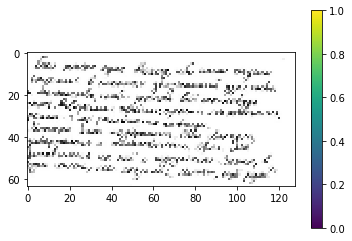

In [22]:
plt.figure()
plt.imshow(x_test[15])
plt.colorbar()
plt.grid(False)
plt.show()

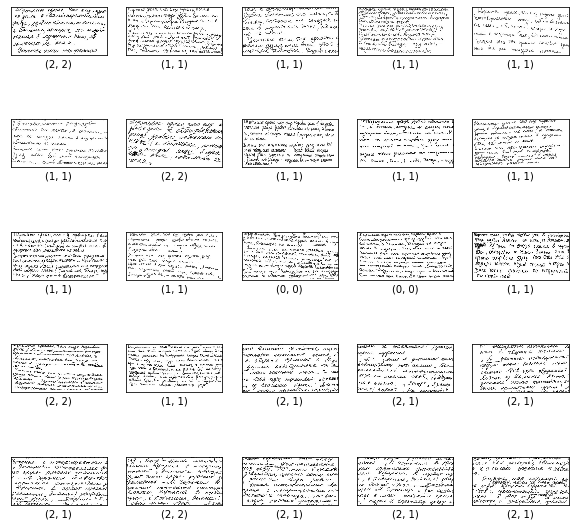

In [24]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_test[i+25], cmap=plt.cm.binary)
    plt.xlabel((y_test[i+25],np.argmax(pred[i+25])))
plt.show()

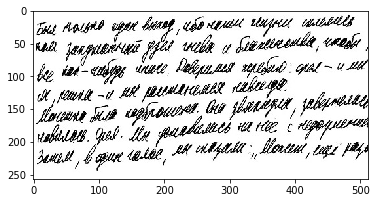

In [32]:
way='106.jpg'
#img = Image.open(way)
img = cv2.imread(way)
plt.imshow(img)
img = cv2.resize(img, (hei, wei)) / 255.

In [0]:
'''def binarize_array(numpy_array):
    """Binarize a numpy array."""
    for i in range(len(numpy_array)):
        for j in range(len(numpy_array[0])):
            if (numpy_array[i][j][0] > 150 and numpy_array[i][j][1] > 150 and numpy_array[i][j][2] > 150
                or numpy_array[i][j][0] > 180 or numpy_array[i][j][1] > 180 or numpy_array[i][j][2] > 180):
                numpy_array[i][j] = 255
            else:
                numpy_array[i][j] = 0
    return numpy_array
img = binarize_array(img)
img = cv2.resize(img, (hei, wei))
plt.imshow(img)'''

In [0]:
pred_img = model.predict(img.reshape(1,wei,hei,3))

In [34]:
print('Pred_img: ',np.argmax(pred_img))

Pred_img:  2
